Set to true if the notebook is on google colab

In [1]:
colab_notebook = False

### Set up the directories

In [2]:
import os
from pathlib import Path

if colab_notebook:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    dstn = "/content/" # location of where to save the data
else:
    dstn = os.path.join(os.getcwd(), 'data')

save_dir = Path("results/") # where to store results
save_dir.mkdir(parents=True, exist_ok=True)

### Import libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
if colab_notebook:
    %pip install torchdiffeq
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.datasets import ImageFolder
import os, glob, random, shutil
from PIL import Image, ImageDraw, ImageFont
import math
from torch.utils.data import Subset
from tqdm.auto import tqdm
from pathlib import Path
from torchvision.utils import save_image
import re
import matplotlib.font_manager as fm 

/Users/micheledisabato/Documents/courses/WASPCourses/DeepLearning_WASP2025/deep-learning-m3/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chose the dataset

In [4]:
data_identifier = 'MNIST'
# data_identifier = 'FashionMNIST'

### Resize and preprocess all images, define dataloader (batch size is used in the Monte Carlo estimate for the mean in the loss function)

/Users/micheledisabato/Documents/courses/WASPCourses/DeepLearning_WASP2025/deep-learning-m3/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


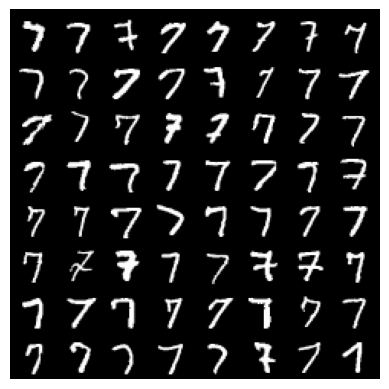

Batch shape: torch.Size([64, 1, 28, 28]) | unique labels: [7]
In total there are 6272 images


In [5]:
if data_identifier == 'MNIST':
    
    bs = 64 # batch size

    MNIST_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) 
    ])

    train_ds = datasets.MNIST(dstn, train=True,  download=True, transform=MNIST_tf)
    test_ds  = datasets.MNIST(dstn, train=False, download=True, transform=MNIST_tf)

    def only_digit_subset(ds, digit=1):
        """
        Keep only one class (digit) of the MNIST dataset
        """
        targets = getattr(ds, "targets", getattr(ds, "train_labels", None))
        idx = (targets == digit).nonzero(as_tuple=True)[0]
        return Subset(ds, idx)

    n = None # number of images to keep
    subset_train_ds = only_digit_subset(train_ds, 7)
    if n is not None:
        subset_train_ds = Subset(subset_train_ds, range(n))

    train_loader_MNIST = DataLoader(subset_train_ds, batch_size=bs, shuffle=True,  num_workers=0, pin_memory=False)
    test_loader_MNIST = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

    imgs, labels = next(iter(train_loader_MNIST))
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, value_range=(-1, 1))
    plt.imshow(grid.permute(1, 2, 0).cpu().squeeze(-1), cmap="gray") # resize the image to make it of size (B, Channels, Height, Width)
    plt.axis("off"); plt.show()
    print("Batch shape:", imgs.shape, "| unique labels:", labels.unique().tolist())

    print(f"In total there are {len(train_loader_MNIST)*bs} images")

In [6]:
if data_identifier == 'FashionMNIST':

    bs = 64

    fMNIST_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_ds = datasets.FashionMNIST(dstn, train=True,  download=True, transform=fMNIST_tf)
    test_ds  = datasets.FashionMNIST(dstn, train=False, download=True, transform=fMNIST_tf)

    fashion_classes = [
        "T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"
    ]
    def class_subset(ds, target):
        """
        Keep only one class
        """
        targets = getattr(ds, "targets", getattr(ds, "train_labels", None))
        if isinstance(target, str):
            cls_idx = fashion_classes.index(target)
        else:
            cls_idx = int(target)
        idx = (targets == cls_idx).nonzero(as_tuple=True)[0]
        return Subset(ds, idx), cls_idx

    n = None
    target_class = "Bag"
    subset_train_ds, cls_idx = class_subset(train_ds, target_class)
    if n is not None:
        train_one = Subset(subset_train_ds, range(n))

    train_loader_fMNIST = DataLoader(subset_train_ds, batch_size=bs, shuffle=True,  num_workers=0, pin_memory=False)
    test_loader_fMNIST  = DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)

    imgs, labels = next(iter(train_loader_fMNIST))
    print(f"class kept: {fashion_classes[cls_idx]} (index {cls_idx})")
    print("Batch shape:", imgs.shape, "| unique labels:", labels.unique().tolist())

    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, value_range=(-1,1))
    plt.imshow(grid.permute(1,2,0).cpu().squeeze(-1), cmap="gray")
    plt.axis("off"); plt.show()

    print(f"In total there are {len(train_loader_fMNIST)*bs} images")

### Set the training DataLoader

In [7]:
if data_identifier == 'FashionMNIST':
    train_loader = train_loader_fMNIST
if data_identifier == 'MNIST':
    train_loader = train_loader_MNIST

### Define time embedding

In [8]:
class SinusoidalTimeEmbedding(nn.Module):
    """
    Class to embed time
    """
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: (B,) in [0,1]
        returns: (B, dim)
        """
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(
            torch.linspace(math.log(1.0), math.log(1000.0), half, device=device)
        )
        # [B, half]
        angles = t[:, None] * freqs[None, :] * 2.0 * math.pi
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1), mode="constant")
        return emb

class TimeMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.emb = SinusoidalTimeEmbedding(dim)
        self.net = nn.Sequential(
            nn.SiLU(),
            nn.Linear(dim, dim*2),
            nn.SiLU(),
            nn.Linear(dim*2, dim)
        )
    def forward(self, t):
        return self.net(self.emb(t))

### Define the model

In [9]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim, groups=1):
        super().__init__()
        self.norm1 = nn.GroupNorm(groups, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time = nn.Linear(t_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.time(t_emb)[:, :, None, None]
        h = self.conv2(F.silu(self.norm2(h)))
        return h + self.skip(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim):
        super().__init__()
        self.block1 = ResBlock(in_ch,  out_ch, t_dim)
        self.block2 = ResBlock(out_ch, out_ch, t_dim)
        self.down   = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)
    def forward(self, x, t_emb):
        x = self.block1(x, t_emb)
        #x = self.block2(x, t_emb)
        skip = x
        x = self.down(x)
        return x, skip

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, t_dim):
        super().__init__()
        self.up     = nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1)
        self.block1 = ResBlock(out_ch + skip_ch, out_ch, t_dim)  # <--  in_ch = out_ch+skip_ch
        self.block2 = ResBlock(out_ch, out_ch, t_dim)

    def forward(self, x, skip, t_emb):
        x = self.up(x)                     # (B, out_ch, H, W)
        assert x.shape[2:] == skip.shape[2:], f"Upsample mismatch: x {x.shape}, skip {skip.shape}"
        x = torch.cat([x, skip], dim=1)    # (B, out_ch+skip_ch, H, W)
        x = self.block1(x, t_emb)
        #x = self.block2(x, t_emb)
        return x

class UNetVectorField(nn.Module):
    def __init__(self, in_ch=3, base_ch=64, levels=3, t_dim=256):
        super().__init__()
        self.t_mlp = TimeMLP(t_dim)
        chs = [base_ch * (2**i) for i in range(levels)]       # [64,128,256]
        self.in_conv = nn.Conv2d(in_ch, chs[0], 3, padding=1)
        self.downs = nn.ModuleList([Down(chs[i], chs[i+1], t_dim) for i in range(levels-1)])
        self.mid1 = ResBlock(chs[-1], chs[-1], t_dim)
        self.mid2 = ResBlock(chs[-1], chs[-1], t_dim)
        self.ups = nn.ModuleList([
            Up(chs[i+1], chs[i+1], chs[i], t_dim)   # in_ch, skip_ch, out_ch
            for i in reversed(range(levels-1))
        ])
        self.out_norm = nn.GroupNorm(8, chs[0])
        self.out_conv = nn.Conv2d(chs[0], in_ch, 3, padding=1)

    def forward(self, x_t, t):
        t_emb = self.t_mlp(t)
        x = self.in_conv(x_t)
        skips = []
        for d in self.downs:
            x, s = d(x, t_emb); skips.append(s)
        x = self.mid1(x, t_emb); x = self.mid2(x, t_emb)
        for u in self.ups:
            s = skips.pop()
            x = u(x, s, t_emb)
        x = F.silu(self.out_norm(x))
        return self.out_conv(x)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m, nn.GroupNorm):
        nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

### Define Flow Matching functions

In [10]:
def center_crop_to_multiple(x, m: int):
    """
    This function makest he Height and Width of the image compatible with the number of calls to the Down function in the U-Net
    """
    B, C, H, W = x.shape
    H2, W2 = (H // m) * m, (W // m) * m
    if H2 == H and W2 == W:
        return x
    top, left = (H - H2) // 2, (W - W2) // 2
    return x[:, :, top:top+H2, left:left+W2]


def psi_t(x0, x1, t, sigma_min):
    """
    Conditional flow
    """
    a = (1.0 - (1.0 - sigma_min) * t)[:, None, None, None]   # (B,1,1,1)
    return a * x0 + t[:, None, None, None] * x1              # (B,C,H,W)


def target_field(x0, x1, sigma_min):
    """
    Target field
    """
    return x1 - (1.0 - sigma_min) * x0                       # (B,C,H,W)

### Define functions for training and training parameters

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 100 if colab_notebook else 20
levels = 3                # == number of downsamples / number of times that Down is called
stride = 2 ** levels      # the Height and Width of the images need to be divisible by stride
sigma_min = 0.08          # needs to be small to satisfy requirements for conditional probability p_t(x | x_1) as in Section 3.2 of (Lipman et al. 2023)
bc = 32
field = UNetVectorField(in_ch=imgs.shape[1], base_ch=bc, levels=levels, t_dim=256).to(device)
"""
field.apply(init_weights)                                                                     # initialize network
for m in field.modules():
    if isinstance(m, ResBlock):
        nn.init.zeros_(m.conv2.weight)
        if m.conv2.bias is not None: nn.init.zeros_(m.conv2.bias)
nn.init.zeros_(field.out_conv.weight)
if field.out_conv.bias is not None: nn.init.zeros_(field.out_conv.bias)
"""
opt = torch.optim.Adam(field.parameters(), lr=1e-3)                                           # optimizer
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs*len(train_loader))   # learning rate scheduler 

def train_step(batch_imgs):
    """
    This function performs one step of the training procedure
    """
    field.train()
    x1 = batch_imgs.to(device)                                # choose the final images [size: (B,C,H,W)]
    x1 = center_crop_to_multiple(x1, stride)                  # ensure that the image is big enough
    B = x1.size(0)                                            # get the number of Monte Carlo samples (== batch size)
    x0 = torch.randn_like(x1)                                 # sample random noise from N(0,I)
    t  = torch.rand(B, device=device)                         # sample random times from U[0,1]
    x_t    = psi_t(x0, x1, t, sigma_min)                      # make the random noise "flow" until time t through psi_t [size: (B,C,H,W)]
    u_star = target_field(x0, x1, sigma_min)                  # target vector field [size: (B,C,H,W)]
    v_pred = field(x_t, t)                                    # predicted vector field [size: (B,C,H,W)]
    loss   = F.mse_loss(v_pred, u_star)                       # MSE loss
    opt.zero_grad(set_to_none=True)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(field.parameters(), 1.0)   # avoid exploding gradient
    opt.step()
    return loss.item()

### Train the model

In [ ]:
loss_history_batchwise = []
loss_history_epochwise = []
for epoch in range(num_epochs):
    epoch_loss_sum = 0
    num_batches = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for imgs, _ in pbar:
    #for imgs in pbar:
        l = train_step(imgs)
        sched.step()
        loss_history_batchwise.append(l)
        epoch_loss_sum += l
        num_batches += 1
        pbar.set_postfix(loss=f"{l:.4f}", lr=f"{sched.get_last_lr()[0]:.2e}")
    loss_history_epochwise.append(epoch_loss_sum / max(1, num_batches))

### Save the values of the loss function

In [12]:
if colab_notebook:
    torch.save(loss_history_epochwise, save_dir / "loss_history_epochwise.pt")
    torch.save(loss_history_batchwise, save_dir / "loss_history_batchwise.pt")

### Save/load the model

In [13]:
if colab_notebook:
    torch.save(field.state_dict(), save_dir / "model_state_FM.pth")
    torch.save({
        "model_state_dict": field.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "scheduler_state_dict": sched.state_dict(),
        "config": {
            "levels": levels, "stride": stride, "sigma_min": sigma_min,
            "num_epochs": num_epochs, "in_ch": int(imgs.shape[1]),
            "base_ch": bc, "t_dim": 256
        }
    }, save_dir / "checkpoint_FM.pt")
    
if not colab_notebook:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    ckpt = torch.load(save_dir / "checkpoint_7_FM.pt", map_location=device)

    cfg = ckpt.get("config", {})
    field_COLAB = UNetVectorField(
        in_ch=cfg.get("in_ch", 1),
        base_ch=cfg.get("base_ch", 32),
        levels=cfg.get("levels", 3),
        t_dim=cfg.get("t_dim", 256),
    ).to(device)

    field_COLAB.load_state_dict(ckpt["model_state_dict"])
    field_COLAB.eval()

### Plot loss function for all epochs and for all batches

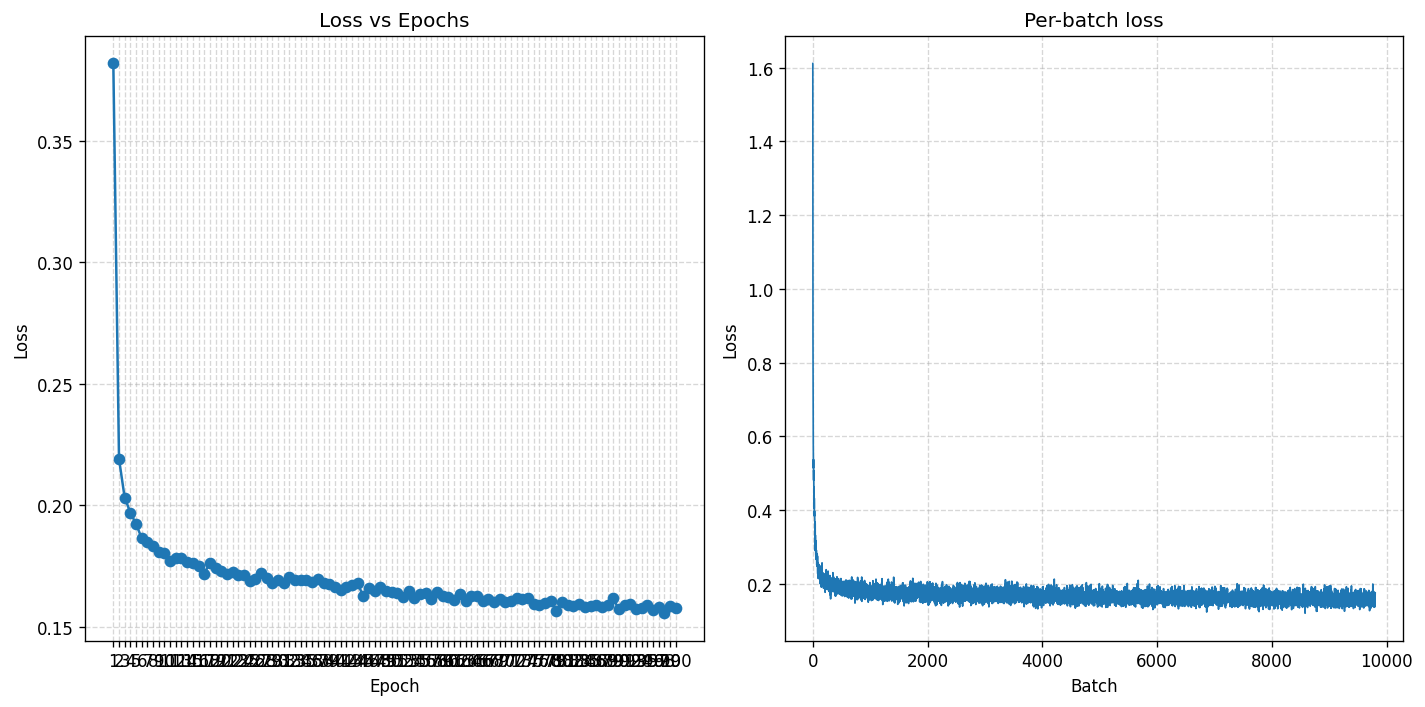

In [ ]:
if not colab_notebook:
    loss_history_epochwise_COLAB = torch.load(save_dir / "loss_history_epochwise_7_FM.pt", map_location="cpu")
    loss_history_batchwise_COLAB = torch.load(save_dir / "loss_history_batchwise_7_FM.pt", map_location="cpu")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=120)

epochs = range(1, len(loss_history_epochwise) + 1)
batches = range(1, len(loss_history_batchwise) + 1)

axes[0].plot(epochs, loss_history_epochwise, marker='o', linewidth=1.5)
axes[0].set_title("Loss vs Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_xticks(list(epochs))
axes[0].grid(True, linestyle="--", alpha=0.5)

axes[1].plot(batches, loss_history_batchwise, linewidth=1, markeredgewidth=0.01)
axes[1].set_title("Per-batch loss")
axes[1].set_xlabel("Batch")
axes[1].set_ylabel("Loss")
#axes[1].set_xticks(list(batches))
axes[1].grid(True, linestyle="--", alpha=0.5)

fig.tight_layout()
plt.show()

### Generate random images

In [ ]:
class CNFDynamics(nn.Module):
    """
    ODE dynamics wrapper for torchdiffeq: f(t, y) -> v_theta(y, t)
    """
    def __init__(self, field):
        super().__init__()
        self.field = field
    def forward(self, t, y):    # y: (B,C,H,W); t: scalar tensor
        t_batch = torch.full((y.shape[0],), float(t), device=y.device, dtype=y.dtype)
        return self.field(y, t_batch)

def sample_via_ode(t_val=1.0, H: int = 128, W: int = 128, ch=3, method: str = "dopri5",
                   plot=True, return_uint8=True, verbose = True):
    """
    Solve x'(t)=v_theta(x,t) with odeint, starting from x(0) ~ N(0,I).
    - t_val: float or list of floats in [0,1]. If list, plots each generated image.
    - H,W: image size (will be center-cropped to be divisible by 2**levels).
    - return_uint8: if True, return images as uint8 on CPU for memory efficiency.
    Returns:
        imgs_out: Tensor [T,C,H,W] (uint8 if return_uint8 else float)
        t_eval:   Tensor [T] times (float32, on CPU)
    """
    field_COLAB.eval()
    with torch.no_grad():
        if verbose:
            print("1) Start from noise at t=0")
        x0 = torch.randn(1, ch, H, W, device=device)
        x0 = center_crop_to_multiple(x0, stride)

        if verbose:
            print("2) Time grid for the solver")
        t_list = [float(tv) for tv in (t_val if isinstance(t_val, (list, tuple)) else [t_val])]
        t_list = sorted(t_list)
        t_eval = torch.tensor(t_list, device=device, dtype=torch.float32)

        if verbose: 
            print("3) Integrate ODE once over all requested times")
        dyn = CNFDynamics(field_COLAB).to(device)
        sol = odeint(dyn, x0, t_eval, method=method, rtol=1e-6, atol=1e-6)  # (T,1,C,H,W)

        imgs = sol[:, 0]  # (T,C,H,W)
        if return_uint8: 
            imgs_out = ((imgs.clamp(-1, 1) + 1) * 127.5).round().to(torch.uint8).cpu()
        else:
            imgs_out = imgs.detach().cpu() 

        if plot:
            if verbose:
                print("4) Plot each generated image x_t")
            n = len(t_list)
            n_cols = 5
            n_rows = (n + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), dpi=120)
            axes = np.ravel(axes) if n_rows * n_cols > 1 else np.array([axes])

            for k, tv in enumerate(t_list):
                x_t = imgs_out[k]
                if return_uint8:
                    x_vis = x_t.float() / 255.0
                else:
                    x_vis = (x_t.clamp(-1, 1) + 1) / 2
                img = x_vis.permute(1, 2, 0).numpy() if x_vis.shape[0] > 1 else x_vis[0].numpy()

                ax = axes[k]
                ax.imshow(img, cmap="gray" if img.ndim == 2 else None)
                ax.set_title(f"Generated sample at t={tv}")
                ax.axis("off")

            for j in range(n, n_rows * n_cols):
                axes[j].axis("off")

            plt.tight_layout()
            plt.show()

        return imgs_out, t_eval.cpu() 


gen1 = sample_via_ode(t_val=[0.0, 0.25, 0.5, 0.75, 1.0], ch = imgs.shape[1], H=imgs.shape[2], W=imgs.shape[3], method = "dopri5", plot = True, return_uint8=True, verbose=True)

if colab_notebook:
    gen2 = sample_via_ode(t_val=[0.0, 0.25, 0.5, 0.75, 1.0], ch = imgs.shape[1], H=imgs.shape[2], W=imgs.shape[3], method = "dopri5", plot = False, return_uint8=True, verbose=False)
    gen3 = sample_via_ode(t_val=[0.0, 0.25, 0.5, 0.75, 1.0], ch = imgs.shape[1], H=imgs.shape[2], W=imgs.shape[3], method = "dopri5", plot = False, return_uint8=True, verbose=False)
    gen4 = sample_via_ode(t_val=[0.0, 0.25, 0.5, 0.75, 1.0], ch = imgs.shape[1], H=imgs.shape[2], W=imgs.shape[3], method = "dopri5", plot = False, return_uint8=True, verbose=False)
    gen5 = sample_via_ode(t_val=[0.0, 0.25, 0.5, 0.75, 1.0], ch = imgs.shape[1], H=imgs.shape[2], W=imgs.shape[3], method = "dopri5", plot = False, return_uint8=True, verbose=False)

    gens = {
        "gen1": {"imgs": gen1[0], "t_eval": gen1[1]},
        "gen2": {"imgs": gen2[0], "t_eval": gen2[1]},
        "gen3": {"imgs": gen3[0], "t_eval": gen3[1]},
        "gen4": {"imgs": gen4[0], "t_eval": gen4[1]},
        "gen5": {"imgs": gen5[0], "t_eval": gen5[1]},
    }
    torch.save(gens, save_dir / "gen_images_report_FM.pt")

In [ ]:
if False:
    gen50 = sample_via_ode(t_val=list(np.linspace(0,1,50)), ch = imgs.shape[1], H=imgs.shape[2], W=imgs.shape[3], method = "dopri5", plot = False, return_uint8=True, verbose=False)

    if os.path.isdir("images_report/images_animation_7_FM"): shutil.rmtree("images_report/images_animation_7_FM")
    os.makedirs("images_report/images_animation_7_FM", exist_ok=True)

    imgs_, vals_ = gen50
    for im, v in zip(imgs_, vals_):
        Image.fromarray(
            (im if im.dtype==torch.uint8 else ((im+1)*127.5).round().to(torch.uint8))
            .permute(1,2,0).cpu().numpy().squeeze()
        ).resize((im.shape[-1]*16, im.shape[-2]*16), Image.NEAREST).save(
            f"images_report/images_animation_7_FM/{str(float(v)).replace('.','')}.png", dpi=(1000,1000)
        )


    dirpath = "images_report/images_animation_7_FM"
    files = [f for f in os.listdir(dirpath) if re.fullmatch(r"\d+\.(png|jpg|jpeg)", f, re.I)]

    def t_from_stem(stem):
        head, tail = stem[0], stem[1:]
        return int(head) + (int(tail) / (10 ** len(tail)) if tail else 0.0)

    files.sort(key=lambda f: t_from_stem(os.path.splitext(f)[0]))

    frames = []
    for f in files:
        im = Image.open(os.path.join(dirpath, f)).convert("RGB")
        t = t_from_stem(os.path.splitext(f)[0])

        font_path = fm.findfont("DejaVu Sans", fallback_to_default=True)
        font = ImageFont.truetype(font_path, size=max(im.size)//10)  # big font

        draw = ImageDraw.Draw(im)
        draw.text((30, 30), f"t = {t:.2f}", fill="red", stroke_width=4, stroke_fill="black", font=font)
        frames.append(im)

    frames[0].save(os.path.join(dirpath, "animation_7.gif"), save_all=True, append_images=frames[1:], duration=120, loop=0)


### Generate many images

In [ ]:
N = 200

if colab_notebook:
    gens = {}
    times = []

    for n in tqdm(range(1, N + 1), desc="Generating", leave=False):
        imgs_out, t_eval = sample_via_ode(
            t_val=[0., 1.],
            ch=imgs.shape[1], H=imgs.shape[2], W=imgs.shape[3],
            method="dopri5", plot=False, return_uint8=True, verbose = False
        )
        gens[n] = {"imgs": imgs_out[1, :, :, :], "t_eval": t_eval[-1].detach().cpu()}

    # torch.save(gens, os.path.join(os.getcwd(), 'results/generated_images_FM.pt'))
    torch.save(gens, save_dir / "generated_images_FM.pt")
    
if not colab_notebook:
    # gens = torch.load(os.path.join(os.getcwd(), 'results/generated_images_FM.pt'), map_location="cpu")
    gens = torch.load(save_dir / "generated_images_7_FM.pt", map_location="cpu")